In [1]:
import numpy as np
from mindquantum.core.gates import X, Y, Z, S, H, RX, RY, RZ, Measure, UnivMathGate, DepolarizingChannel
from mindquantum.core.circuit import Circuit
from mindquantum.simulator import Simulator
import scipy.linalg as la
import matplotlib.pyplot as plt
from tqdm import tqdm
import concurrent.futures
import os
from scipy.optimize import curve_fit   

In [51]:
def SpinChain(n,J,h):
    X = np.array([[0, 1], [1, 0]],dtype=complex)
    Y = np.array([[0, -1j], [1j, 0]],dtype=complex)
    Z = np.array([[1, 0], [0, -1]],dtype=complex)
    def hopping(P,i):
        assert i < n, "i should be less than n"
        if i == 0 or i == n-1:
            matrix = P
        else:
            matrix = np.eye(2,dtype=complex)
        for j in range(1,n):
            if j == i or j == i+1:
                matrix = np.kron(P,matrix)
            else:
                matrix = np.kron(np.eye(2,dtype=complex),matrix)
        return matrix
    def potential(P,i):
        assert i < n, "i should be less than n"
        if i == 0:
            matrix = P
        else:
            matrix = np.eye(2,dtype=complex)
        for j in range(1,n):
            if j == i:
                matrix = np.kron(P,matrix)
            else:
                matrix = np.kron(np.eye(2,dtype=complex),matrix)
        return matrix
    
    # hopping term
    HoppingX = np.zeros((2**n,2**n),dtype=complex)
    HoppingY = np.zeros((2**n,2**n),dtype=complex)
    HoppingZ = np.zeros((2**n,2**n),dtype=complex)
    if n == 2:
        for i in range(n-1):
            HoppingX += hopping(X,i)*J[0]
            HoppingY += hopping(Y,i)*J[1]
            HoppingZ += hopping(Z,i)*J[2]
    else:
        for i in range(n):
            HoppingX += hopping(X,i)*J[0]
            HoppingY += hopping(Y,i)*J[1]
            HoppingZ += hopping(Z,i)*J[2]
    # potential term
    PotentialX = np.zeros((2**n,2**n),dtype=complex)
    PotentialY = np.zeros((2**n,2**n),dtype=complex)
    PotentialZ = np.zeros((2**n,2**n),dtype=complex)
    for i in range(n):
        PotentialX += potential(X,i)*h[0]
        PotentialY += potential(Y,i)*h[1]
        PotentialZ += potential(Z,i)*h[2]
    return HoppingX+HoppingY+HoppingZ+PotentialX+PotentialY+PotentialZ

def TimeEvolution(H,t):
    eigenv,U = np.linalg.eig(H)
    diag = np.diag(np.exp(-1.j*t*eigenv))
    return U@diag@np.linalg.inv(U)

def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2))

def Diag_averg(matrix_set):
    L = matrix_set.shape[0]
    K = matrix_set.shape[1]
    N = L+K-1
    Y = matrix_set
    def sum(seq):
        a = seq[0]
        for i in range(1,len(seq)):
            a += seq[i]
        return a     
    recovered = []
    for i in range(N):
        if i<=L-1:
            seq = [Y[m,i-m]/(i+1) for m in range(i+1)]
            recovered.append(sum(seq))
        elif i>L-1 and i<K-1:
            seq = [Y[m,i-m]/L for m in range(L)]
            recovered.append(sum(seq))
        else:
            seq = [Y[m,i-m]/(N-i) for m in range(i-K+1,L)]
            recovered.append(sum(seq))
    return np.array(recovered)

def TimeSeqRecover(time_sequence_error,order):
    N = len(time_sequence_error)
    L = N//2
    K = N-L+1
    X = []
    for i in range(K):
        X.append(time_sequence_error[i:i+L])
    X = np.array(X).T
    U,Lambda,V = np.linalg.svd(X)
    r = order
    Y = U[:,:r]@np.diag(Lambda[:r])@V[:r,:]
    # print(Lambda[:2*r])
    time_sequence_recover = Diag_averg(Y)
    return time_sequence_recover

def QSA(Hamiltonian,ground_state,error=0.0,size=1000,with_SSA=True):
    n = int(np.log2(Hamiltonian.shape[0]))
    target_bit = [i+1 for i in range(n)]
    sim = Simulator('mqvector',n+1)

    sigma = 3.0
    points = 30
    width = 2.0*sigma

    time_stamp = np.linspace(-width,width,points+1)
    print('time_stamp:', time_stamp)
    coeffs = [(width*2/points)*np.exp(-time_stamp[j]**2/(2*sigma**2))/(sigma*np.sqrt(2*np.pi)) for j in range(points+1)]

    U0 = TimeEvolution(Hamiltonian,-width)
    dU = TimeEvolution(Hamiltonian,2*width/points)
    Uset = []
    for i in tqdm(range(points+1)):
        randmat = np.random.randn(2**n,2**n)+1.j*np.random.randn(2**n,2**n)
        randmat = randmat*error
        Uset.append(U0)
        U0 = (dU+randmat)@U0
    Uset = np.array(Uset)

    # time_serial
    time_serial = []
    for i in tqdm(range(points+1),desc='I',colour='yellow'): # t
        realcirc = Circuit()
        realcirc += H.on(0)
        evol_gate = UnivMathGate('Ut',Uset[i])
        realcirc += evol_gate.on(target_bit,0)
        realcirc += H.on(0)
        realcirc += Measure('q0').on(0)
        
        sim.reset()
        sim.set_qs(np.kron(ground_state,[1.0,0.0]))
        result = sim.sampling(circuit=realcirc,shots=size)
        samples = result.data
        try:
            zero = samples['0']
        except:
            zero = 0
        try:
            one = samples['1']
        except:
            one = 0
        real_part = (zero-one)/size

        imagcirc = Circuit()
        imagcirc += H.on(0)
        evol_gate = UnivMathGate('Ut',Uset[i])
        imagcirc += evol_gate.on(target_bit,0)
        imagcirc += S.on(0)
        imagcirc += Z.on(0)
        imagcirc += H.on(0)
        imagcirc += Measure('q0').on(0)

        sim.reset()
        sim.set_qs(np.kron(ground_state,[1.0,0.0]))
        result = sim.sampling(circuit=imagcirc,shots=size)
        samples = result.data
        try:
            zero = samples['0']
        except:
            zero = 0
        try:
            one = samples['1']
        except:
            one = 0
        imag_part = (zero-one)/size

        time_serial.append(real_part+1.j*imag_part)

        del realcirc
        del imagcirc  
    time_serial = np.array(time_serial) 

    # post - processing
    if with_SSA:
        time_serial_recover = TimeSeqRecover(time_serial,2)
    else:
        time_serial_recover = time_serial
    energy_stamp = np.linspace(-23,-2,4319)

    amplitude = []
    for energy in energy_stamp:
        coeffs = []
        for i in range(points+1):
            coeffs.append((width*2/points)*np.exp(-time_stamp[i]**2/(2*sigma**2)+1.j*energy*time_stamp[i])/(sigma*np.sqrt(2*np.pi)))
        amplitude.append(np.array(coeffs)@time_serial_recover)
    try:
        plt.plot(energy_stamp[:600],np.real(amplitude)[:600])
        popt, pcov = curve_fit(gaussian, energy_stamp[:600], np.real(amplitude[:600]), p0=[0.1,-21.5,1])
        estimated_energy = popt[1]
    except:
        pass

    return estimated_energy

In [52]:
n = 8
size = 1000
J = [-1.0,-1.0,-1.5]
h = [1.5,0.0,0.5]
Hamiltonian = SpinChain(n,J,h)
ground_state = 0.9*np.linalg.eig(Hamiltonian)[1][:,0]+np.sqrt(1-0.9**2)*np.linalg.eig(Hamiltonian)[1][:,1]
ground_energy = np.linalg.eigvalsh(Hamiltonian)[0]

samples:   0%|          | 0/10 [00:00<?, ?it/s]

time_stamp: [-6.  -5.6 -5.2 -4.8 -4.4 -4.  -3.6 -3.2 -2.8 -2.4 -2.  -1.6 -1.2 -0.8
 -0.4  0.   0.4  0.8  1.2  1.6  2.   2.4  2.8  3.2  3.6  4.   4.4  4.8
  5.2  5.6  6. ]




100%|██████████| 31/31 [00:00<00:00, 246.03it/s]




I: 100%|██████████| 31/31 [00:00<00:00, 77.40it/s]


time_stamp: [-6.  -5.6 -5.2 -4.8 -4.4 -4.  -3.6 -3.2 -2.8 -2.4 -2.  -1.6 -1.2 -0.8
 -0.4  0.   0.4  0.8  1.2  1.6  2.   2.4  2.8  3.2  3.6  4.   4.4  4.8
  5.2  5.6  6. ]




100%|██████████| 31/31 [00:00<00:00, 238.46it/s]




I: 100%|██████████| 31/31 [00:00<00:00, 74.28it/s]


time_stamp: [-6.  -5.6 -5.2 -4.8 -4.4 -4.  -3.6 -3.2 -2.8 -2.4 -2.  -1.6 -1.2 -0.8
 -0.4  0.   0.4  0.8  1.2  1.6  2.   2.4  2.8  3.2  3.6  4.   4.4  4.8
  5.2  5.6  6. ]




100%|██████████| 31/31 [00:00<00:00, 244.10it/s]




I: 100%|██████████| 31/31 [00:00<00:00, 71.75it/s]


time_stamp: [-6.  -5.6 -5.2 -4.8 -4.4 -4.  -3.6 -3.2 -2.8 -2.4 -2.  -1.6 -1.2 -0.8
 -0.4  0.   0.4  0.8  1.2  1.6  2.   2.4  2.8  3.2  3.6  4.   4.4  4.8
  5.2  5.6  6. ]




100%|██████████| 31/31 [00:00<00:00, 233.08it/s]




I: 100%|██████████| 31/31 [00:00<00:00, 77.50it/s]


time_stamp: [-6.  -5.6 -5.2 -4.8 -4.4 -4.  -3.6 -3.2 -2.8 -2.4 -2.  -1.6 -1.2 -0.8
 -0.4  0.   0.4  0.8  1.2  1.6  2.   2.4  2.8  3.2  3.6  4.   4.4  4.8
  5.2  5.6  6. ]




100%|██████████| 31/31 [00:00<00:00, 205.31it/s]




samples:  10%|█         | 1/10 [00:08<01:19,  8.81s/it]

time_stamp: [-6.  -5.6 -5.2 -4.8 -4.4 -4.  -3.6 -3.2 -2.8 -2.4 -2.  -1.6 -1.2 -0.8
 -0.4  0.   0.4  0.8  1.2  1.6  2.   2.4  2.8  3.2  3.6  4.   4.4  4.8
  5.2  5.6  6. ]




100%|██████████| 31/31 [00:00<00:00, 204.08it/s]




I: 100%|██████████| 31/31 [00:00<00:00, 77.83it/s]


time_stamp: [-6.  -5.6 -5.2 -4.8 -4.4 -4.  -3.6 -3.2 -2.8 -2.4 -2.  -1.6 -1.2 -0.8
 -0.4  0.   0.4  0.8  1.2  1.6  2.   2.4  2.8  3.2  3.6  4.   4.4  4.8
  5.2  5.6  6. ]




100%|██████████| 31/31 [00:00<00:00, 186.75it/s]




I: 100%|██████████| 31/31 [00:00<00:00, 75.02it/s]


time_stamp: [-6.  -5.6 -5.2 -4.8 -4.4 -4.  -3.6 -3.2 -2.8 -2.4 -2.  -1.6 -1.2 -0.8
 -0.4  0.   0.4  0.8  1.2  1.6  2.   2.4  2.8  3.2  3.6  4.   4.4  4.8
  5.2  5.6  6. ]




100%|██████████| 31/31 [00:00<00:00, 200.38it/s]




I: 100%|██████████| 31/31 [00:00<00:00, 77.77it/s]


time_stamp: [-6.  -5.6 -5.2 -4.8 -4.4 -4.  -3.6 -3.2 -2.8 -2.4 -2.  -1.6 -1.2 -0.8
 -0.4  0.   0.4  0.8  1.2  1.6  2.   2.4  2.8  3.2  3.6  4.   4.4  4.8
  5.2  5.6  6. ]




100%|██████████| 31/31 [00:00<00:00, 186.64it/s]




I: 100%|██████████| 31/31 [00:00<00:00, 75.08it/s]


time_stamp: [-6.  -5.6 -5.2 -4.8 -4.4 -4.  -3.6 -3.2 -2.8 -2.4 -2.  -1.6 -1.2 -0.8
 -0.4  0.   0.4  0.8  1.2  1.6  2.   2.4  2.8  3.2  3.6  4.   4.4  4.8
  5.2  5.6  6. ]




100%|██████████| 31/31 [00:00<00:00, 193.75it/s]




samples:  20%|██        | 2/10 [00:17<01:10,  8.81s/it]

time_stamp: [-6.  -5.6 -5.2 -4.8 -4.4 -4.  -3.6 -3.2 -2.8 -2.4 -2.  -1.6 -1.2 -0.8
 -0.4  0.   0.4  0.8  1.2  1.6  2.   2.4  2.8  3.2  3.6  4.   4.4  4.8
  5.2  5.6  6. ]




100%|██████████| 31/31 [00:00<00:00, 162.30it/s]




I: 100%|██████████| 31/31 [00:00<00:00, 70.58it/s]


time_stamp: [-6.  -5.6 -5.2 -4.8 -4.4 -4.  -3.6 -3.2 -2.8 -2.4 -2.  -1.6 -1.2 -0.8
 -0.4  0.   0.4  0.8  1.2  1.6  2.   2.4  2.8  3.2  3.6  4.   4.4  4.8
  5.2  5.6  6. ]




100%|██████████| 31/31 [00:00<00:00, 175.14it/s]




I: 100%|██████████| 31/31 [00:00<00:00, 74.09it/s]


time_stamp: [-6.  -5.6 -5.2 -4.8 -4.4 -4.  -3.6 -3.2 -2.8 -2.4 -2.  -1.6 -1.2 -0.8
 -0.4  0.   0.4  0.8  1.2  1.6  2.   2.4  2.8  3.2  3.6  4.   4.4  4.8
  5.2  5.6  6. ]




100%|██████████| 31/31 [00:00<00:00, 161.45it/s]




I: 100%|██████████| 31/31 [00:00<00:00, 78.31it/s]


time_stamp: [-6.  -5.6 -5.2 -4.8 -4.4 -4.  -3.6 -3.2 -2.8 -2.4 -2.  -1.6 -1.2 -0.8
 -0.4  0.   0.4  0.8  1.2  1.6  2.   2.4  2.8  3.2  3.6  4.   4.4  4.8
  5.2  5.6  6. ]




100%|██████████| 31/31 [00:00<00:00, 200.01it/s]




I: 100%|██████████| 31/31 [00:00<00:00, 76.93it/s]


time_stamp: [-6.  -5.6 -5.2 -4.8 -4.4 -4.  -3.6 -3.2 -2.8 -2.4 -2.  -1.6 -1.2 -0.8
 -0.4  0.   0.4  0.8  1.2  1.6  2.   2.4  2.8  3.2  3.6  4.   4.4  4.8
  5.2  5.6  6. ]




100%|██████████| 31/31 [00:00<00:00, 155.78it/s]




samples:  30%|███       | 3/10 [00:28<01:07,  9.68s/it]

time_stamp: [-6.  -5.6 -5.2 -4.8 -4.4 -4.  -3.6 -3.2 -2.8 -2.4 -2.  -1.6 -1.2 -0.8
 -0.4  0.   0.4  0.8  1.2  1.6  2.   2.4  2.8  3.2  3.6  4.   4.4  4.8
  5.2  5.6  6. ]




100%|██████████| 31/31 [00:00<00:00, 167.57it/s]





I: 100%|██████████| 31/31 [00:00<00:00, 68.26it/s]


time_stamp: [-6.  -5.6 -5.2 -4.8 -4.4 -4.  -3.6 -3.2 -2.8 -2.4 -2.  -1.6 -1.2 -0.8
 -0.4  0.   0.4  0.8  1.2  1.6  2.   2.4  2.8  3.2  3.6  4.   4.4  4.8
  5.2  5.6  6. ]




100%|██████████| 31/31 [00:00<00:00, 204.63it/s]




I: 100%|██████████| 31/31 [00:00<00:00, 73.53it/s]


time_stamp: [-6.  -5.6 -5.2 -4.8 -4.4 -4.  -3.6 -3.2 -2.8 -2.4 -2.  -1.6 -1.2 -0.8
 -0.4  0.   0.4  0.8  1.2  1.6  2.   2.4  2.8  3.2  3.6  4.   4.4  4.8
  5.2  5.6  6. ]




100%|██████████| 31/31 [00:00<00:00, 197.46it/s]




I: 100%|██████████| 31/31 [00:00<00:00, 76.23it/s]


time_stamp: [-6.  -5.6 -5.2 -4.8 -4.4 -4.  -3.6 -3.2 -2.8 -2.4 -2.  -1.6 -1.2 -0.8
 -0.4  0.   0.4  0.8  1.2  1.6  2.   2.4  2.8  3.2  3.6  4.   4.4  4.8
  5.2  5.6  6. ]




100%|██████████| 31/31 [00:00<00:00, 201.09it/s]




I: 100%|██████████| 31/31 [00:00<00:00, 76.16it/s]


time_stamp: [-6.  -5.6 -5.2 -4.8 -4.4 -4.  -3.6 -3.2 -2.8 -2.4 -2.  -1.6 -1.2 -0.8
 -0.4  0.   0.4  0.8  1.2  1.6  2.   2.4  2.8  3.2  3.6  4.   4.4  4.8
  5.2  5.6  6. ]




100%|██████████| 31/31 [00:00<00:00, 155.01it/s]





samples:  40%|████      | 4/10 [00:39<01:01, 10.22s/it]

time_stamp: [-6.  -5.6 -5.2 -4.8 -4.4 -4.  -3.6 -3.2 -2.8 -2.4 -2.  -1.6 -1.2 -0.8
 -0.4  0.   0.4  0.8  1.2  1.6  2.   2.4  2.8  3.2  3.6  4.   4.4  4.8
  5.2  5.6  6. ]




100%|██████████| 31/31 [00:00<00:00, 202.50it/s]




I: 100%|██████████| 31/31 [00:00<00:00, 72.92it/s]


time_stamp: [-6.  -5.6 -5.2 -4.8 -4.4 -4.  -3.6 -3.2 -2.8 -2.4 -2.  -1.6 -1.2 -0.8
 -0.4  0.   0.4  0.8  1.2  1.6  2.   2.4  2.8  3.2  3.6  4.   4.4  4.8
  5.2  5.6  6. ]




100%|██████████| 31/31 [00:00<00:00, 240.31it/s]




I: 100%|██████████| 31/31 [00:00<00:00, 76.70it/s]


time_stamp: [-6.  -5.6 -5.2 -4.8 -4.4 -4.  -3.6 -3.2 -2.8 -2.4 -2.  -1.6 -1.2 -0.8
 -0.4  0.   0.4  0.8  1.2  1.6  2.   2.4  2.8  3.2  3.6  4.   4.4  4.8
  5.2  5.6  6. ]




100%|██████████| 31/31 [00:00<00:00, 215.22it/s]




I: 100%|██████████| 31/31 [00:00<00:00, 82.15it/s]


time_stamp: [-6.  -5.6 -5.2 -4.8 -4.4 -4.  -3.6 -3.2 -2.8 -2.4 -2.  -1.6 -1.2 -0.8
 -0.4  0.   0.4  0.8  1.2  1.6  2.   2.4  2.8  3.2  3.6  4.   4.4  4.8
  5.2  5.6  6. ]




100%|██████████| 31/31 [00:00<00:00, 246.04it/s]




I: 100%|██████████| 31/31 [00:00<00:00, 80.72it/s]


time_stamp: [-6.  -5.6 -5.2 -4.8 -4.4 -4.  -3.6 -3.2 -2.8 -2.4 -2.  -1.6 -1.2 -0.8
 -0.4  0.   0.4  0.8  1.2  1.6  2.   2.4  2.8  3.2  3.6  4.   4.4  4.8
  5.2  5.6  6. ]




100%|██████████| 31/31 [00:00<00:00, 198.70it/s]




samples:  50%|█████     | 5/10 [00:48<00:49,  9.83s/it]

time_stamp: [-6.  -5.6 -5.2 -4.8 -4.4 -4.  -3.6 -3.2 -2.8 -2.4 -2.  -1.6 -1.2 -0.8
 -0.4  0.   0.4  0.8  1.2  1.6  2.   2.4  2.8  3.2  3.6  4.   4.4  4.8
  5.2  5.6  6. ]




100%|██████████| 31/31 [00:00<00:00, 205.30it/s]




I: 100%|██████████| 31/31 [00:00<00:00, 81.67it/s]


time_stamp: [-6.  -5.6 -5.2 -4.8 -4.4 -4.  -3.6 -3.2 -2.8 -2.4 -2.  -1.6 -1.2 -0.8
 -0.4  0.   0.4  0.8  1.2  1.6  2.   2.4  2.8  3.2  3.6  4.   4.4  4.8
  5.2  5.6  6. ]




100%|██████████| 31/31 [00:00<00:00, 191.38it/s]





I: 100%|██████████| 31/31 [00:00<00:00, 64.82it/s]


time_stamp: [-6.  -5.6 -5.2 -4.8 -4.4 -4.  -3.6 -3.2 -2.8 -2.4 -2.  -1.6 -1.2 -0.8
 -0.4  0.   0.4  0.8  1.2  1.6  2.   2.4  2.8  3.2  3.6  4.   4.4  4.8
  5.2  5.6  6. ]




100%|██████████| 31/31 [00:00<00:00, 206.68it/s]




I: 100%|██████████| 31/31 [00:00<00:00, 83.23it/s]


time_stamp: [-6.  -5.6 -5.2 -4.8 -4.4 -4.  -3.6 -3.2 -2.8 -2.4 -2.  -1.6 -1.2 -0.8
 -0.4  0.   0.4  0.8  1.2  1.6  2.   2.4  2.8  3.2  3.6  4.   4.4  4.8
  5.2  5.6  6. ]




100%|██████████| 31/31 [00:00<00:00, 213.70it/s]




I: 100%|██████████| 31/31 [00:00<00:00, 82.21it/s]


time_stamp: [-6.  -5.6 -5.2 -4.8 -4.4 -4.  -3.6 -3.2 -2.8 -2.4 -2.  -1.6 -1.2 -0.8
 -0.4  0.   0.4  0.8  1.2  1.6  2.   2.4  2.8  3.2  3.6  4.   4.4  4.8
  5.2  5.6  6. ]




100%|██████████| 31/31 [00:00<00:00, 216.79it/s]




samples:  60%|██████    | 6/10 [00:57<00:37,  9.49s/it]

time_stamp: [-6.  -5.6 -5.2 -4.8 -4.4 -4.  -3.6 -3.2 -2.8 -2.4 -2.  -1.6 -1.2 -0.8
 -0.4  0.   0.4  0.8  1.2  1.6  2.   2.4  2.8  3.2  3.6  4.   4.4  4.8
  5.2  5.6  6. ]




100%|██████████| 31/31 [00:00<00:00, 209.41it/s]




I: 100%|██████████| 31/31 [00:00<00:00, 81.37it/s]


time_stamp: [-6.  -5.6 -5.2 -4.8 -4.4 -4.  -3.6 -3.2 -2.8 -2.4 -2.  -1.6 -1.2 -0.8
 -0.4  0.   0.4  0.8  1.2  1.6  2.   2.4  2.8  3.2  3.6  4.   4.4  4.8
  5.2  5.6  6. ]




100%|██████████| 31/31 [00:00<00:00, 196.80it/s]




I: 100%|██████████| 31/31 [00:00<00:00, 75.13it/s]


time_stamp: [-6.  -5.6 -5.2 -4.8 -4.4 -4.  -3.6 -3.2 -2.8 -2.4 -2.  -1.6 -1.2 -0.8
 -0.4  0.   0.4  0.8  1.2  1.6  2.   2.4  2.8  3.2  3.6  4.   4.4  4.8
  5.2  5.6  6. ]




100%|██████████| 31/31 [00:00<00:00, 219.87it/s]




I: 100%|██████████| 31/31 [00:00<00:00, 83.13it/s]


time_stamp: [-6.  -5.6 -5.2 -4.8 -4.4 -4.  -3.6 -3.2 -2.8 -2.4 -2.  -1.6 -1.2 -0.8
 -0.4  0.   0.4  0.8  1.2  1.6  2.   2.4  2.8  3.2  3.6  4.   4.4  4.8
  5.2  5.6  6. ]




100%|██████████| 31/31 [00:00<00:00, 194.17it/s]




I: 100%|██████████| 31/31 [00:00<00:00, 79.26it/s]


time_stamp: [-6.  -5.6 -5.2 -4.8 -4.4 -4.  -3.6 -3.2 -2.8 -2.4 -2.  -1.6 -1.2 -0.8
 -0.4  0.   0.4  0.8  1.2  1.6  2.   2.4  2.8  3.2  3.6  4.   4.4  4.8
  5.2  5.6  6. ]




100%|██████████| 31/31 [00:00<00:00, 212.33it/s]




samples:  70%|███████   | 7/10 [01:05<00:27,  9.05s/it]

time_stamp: [-6.  -5.6 -5.2 -4.8 -4.4 -4.  -3.6 -3.2 -2.8 -2.4 -2.  -1.6 -1.2 -0.8
 -0.4  0.   0.4  0.8  1.2  1.6  2.   2.4  2.8  3.2  3.6  4.   4.4  4.8
  5.2  5.6  6. ]




100%|██████████| 31/31 [00:00<00:00, 223.03it/s]




I: 100%|██████████| 31/31 [00:00<00:00, 68.98it/s]


time_stamp: [-6.  -5.6 -5.2 -4.8 -4.4 -4.  -3.6 -3.2 -2.8 -2.4 -2.  -1.6 -1.2 -0.8
 -0.4  0.   0.4  0.8  1.2  1.6  2.   2.4  2.8  3.2  3.6  4.   4.4  4.8
  5.2  5.6  6. ]




100%|██████████| 31/31 [00:00<00:00, 156.99it/s]





I: 100%|██████████| 31/31 [00:00<00:00, 68.02it/s]


time_stamp: [-6.  -5.6 -5.2 -4.8 -4.4 -4.  -3.6 -3.2 -2.8 -2.4 -2.  -1.6 -1.2 -0.8
 -0.4  0.   0.4  0.8  1.2  1.6  2.   2.4  2.8  3.2  3.6  4.   4.4  4.8
  5.2  5.6  6. ]




100%|██████████| 31/31 [00:00<00:00, 206.60it/s]




I: 100%|██████████| 31/31 [00:00<00:00, 83.35it/s]


time_stamp: [-6.  -5.6 -5.2 -4.8 -4.4 -4.  -3.6 -3.2 -2.8 -2.4 -2.  -1.6 -1.2 -0.8
 -0.4  0.   0.4  0.8  1.2  1.6  2.   2.4  2.8  3.2  3.6  4.   4.4  4.8
  5.2  5.6  6. ]




100%|██████████| 31/31 [00:00<00:00, 180.24it/s]




I: 100%|██████████| 31/31 [00:00<00:00, 77.79it/s]


time_stamp: [-6.  -5.6 -5.2 -4.8 -4.4 -4.  -3.6 -3.2 -2.8 -2.4 -2.  -1.6 -1.2 -0.8
 -0.4  0.   0.4  0.8  1.2  1.6  2.   2.4  2.8  3.2  3.6  4.   4.4  4.8
  5.2  5.6  6. ]




100%|██████████| 31/31 [00:00<00:00, 197.53it/s]




samples:  80%|████████  | 8/10 [01:15<00:18,  9.21s/it]

time_stamp: [-6.  -5.6 -5.2 -4.8 -4.4 -4.  -3.6 -3.2 -2.8 -2.4 -2.  -1.6 -1.2 -0.8
 -0.4  0.   0.4  0.8  1.2  1.6  2.   2.4  2.8  3.2  3.6  4.   4.4  4.8
  5.2  5.6  6. ]




100%|██████████| 31/31 [00:00<00:00, 183.34it/s]




I: 100%|██████████| 31/31 [00:00<00:00, 78.17it/s]


time_stamp: [-6.  -5.6 -5.2 -4.8 -4.4 -4.  -3.6 -3.2 -2.8 -2.4 -2.  -1.6 -1.2 -0.8
 -0.4  0.   0.4  0.8  1.2  1.6  2.   2.4  2.8  3.2  3.6  4.   4.4  4.8
  5.2  5.6  6. ]




100%|██████████| 31/31 [00:00<00:00, 218.21it/s]




I: 100%|██████████| 31/31 [00:00<00:00, 77.50it/s]


time_stamp: [-6.  -5.6 -5.2 -4.8 -4.4 -4.  -3.6 -3.2 -2.8 -2.4 -2.  -1.6 -1.2 -0.8
 -0.4  0.   0.4  0.8  1.2  1.6  2.   2.4  2.8  3.2  3.6  4.   4.4  4.8
  5.2  5.6  6. ]




100%|██████████| 31/31 [00:00<00:00, 196.17it/s]




I: 100%|██████████| 31/31 [00:00<00:00, 72.14it/s]


time_stamp: [-6.  -5.6 -5.2 -4.8 -4.4 -4.  -3.6 -3.2 -2.8 -2.4 -2.  -1.6 -1.2 -0.8
 -0.4  0.   0.4  0.8  1.2  1.6  2.   2.4  2.8  3.2  3.6  4.   4.4  4.8
  5.2  5.6  6. ]




100%|██████████| 31/31 [00:00<00:00, 161.41it/s]





I: 100%|██████████| 31/31 [00:00<00:00, 68.52it/s]


time_stamp: [-6.  -5.6 -5.2 -4.8 -4.4 -4.  -3.6 -3.2 -2.8 -2.4 -2.  -1.6 -1.2 -0.8
 -0.4  0.   0.4  0.8  1.2  1.6  2.   2.4  2.8  3.2  3.6  4.   4.4  4.8
  5.2  5.6  6. ]




100%|██████████| 31/31 [00:00<00:00, 164.10it/s]





samples:  90%|█████████ | 9/10 [01:24<00:09,  9.35s/it]

time_stamp: [-6.  -5.6 -5.2 -4.8 -4.4 -4.  -3.6 -3.2 -2.8 -2.4 -2.  -1.6 -1.2 -0.8
 -0.4  0.   0.4  0.8  1.2  1.6  2.   2.4  2.8  3.2  3.6  4.   4.4  4.8
  5.2  5.6  6. ]




100%|██████████| 31/31 [00:00<00:00, 237.49it/s]




I: 100%|██████████| 31/31 [00:00<00:00, 80.72it/s]


time_stamp: [-6.  -5.6 -5.2 -4.8 -4.4 -4.  -3.6 -3.2 -2.8 -2.4 -2.  -1.6 -1.2 -0.8
 -0.4  0.   0.4  0.8  1.2  1.6  2.   2.4  2.8  3.2  3.6  4.   4.4  4.8
  5.2  5.6  6. ]




100%|██████████| 31/31 [00:00<00:00, 254.12it/s]




I: 100%|██████████| 31/31 [00:00<00:00, 79.09it/s]


time_stamp: [-6.  -5.6 -5.2 -4.8 -4.4 -4.  -3.6 -3.2 -2.8 -2.4 -2.  -1.6 -1.2 -0.8
 -0.4  0.   0.4  0.8  1.2  1.6  2.   2.4  2.8  3.2  3.6  4.   4.4  4.8
  5.2  5.6  6. ]




100%|██████████| 31/31 [00:00<00:00, 196.21it/s]




I: 100%|██████████| 31/31 [00:00<00:00, 78.56it/s]


time_stamp: [-6.  -5.6 -5.2 -4.8 -4.4 -4.  -3.6 -3.2 -2.8 -2.4 -2.  -1.6 -1.2 -0.8
 -0.4  0.   0.4  0.8  1.2  1.6  2.   2.4  2.8  3.2  3.6  4.   4.4  4.8
  5.2  5.6  6. ]




100%|██████████| 31/31 [00:00<00:00, 198.58it/s]




I: 100%|██████████| 31/31 [00:00<00:00, 72.09it/s]


time_stamp: [-6.  -5.6 -5.2 -4.8 -4.4 -4.  -3.6 -3.2 -2.8 -2.4 -2.  -1.6 -1.2 -0.8
 -0.4  0.   0.4  0.8  1.2  1.6  2.   2.4  2.8  3.2  3.6  4.   4.4  4.8
  5.2  5.6  6. ]




100%|██████████| 31/31 [00:00<00:00, 184.93it/s]




samples: 100%|██████████| 10/10 [01:32<00:00,  9.28s/it]


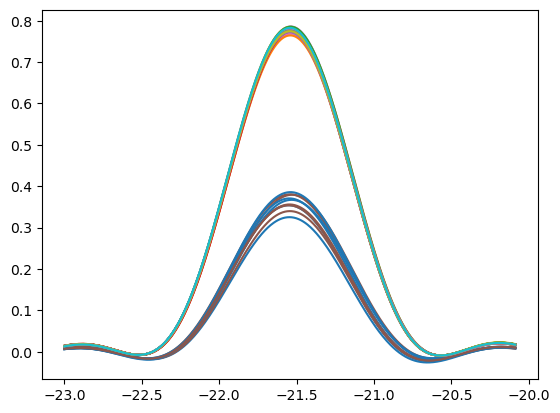

In [53]:
# with SSA
dU_error = [1e-2,1e-3,1e-4,1e-5,0]
samples = []
for i in tqdm(range(10),desc='samples',colour='blue'):
    energy_error = []
    for e in tqdm(dU_error,desc='error',colour='red'):
        estimate_energy = QSA(Hamiltonian=Hamiltonian,ground_state=ground_state,error=e,with_SSA=True)
        energy_error.append(estimate_energy-ground_energy)
    samples.append(energy_error)

In [54]:
post_samples = np.array(np.abs(samples)).T
benchmark = []
for i in range(len(dU_error)):
    benchmark.append((np.mean(post_samples[i]),np.std(post_samples[i])))
benchmark = np.array(benchmark)
print('mean:',benchmark[:,0])
print('std:',benchmark[:,1])

mean: [0.00719243 0.00125051 0.001857   0.00189544 0.00213355]
std: [0.00387161 0.00097321 0.00051542 0.00151049 0.00086668]
